In [1]:
import os
%matplotlib inline
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoviews as gv
import fiona

# 2018 General Election Data Cleaning
This notebook cleans, manipulates, and preprocesses 2018 Election Data provided by [Elections Ontario](https://www.elections.on.ca/en.html) for Analysis and Geoplotting.
## Ontario Shapefile to Geopandas Dataframe

INFO:Fiona:Failed to auto identify EPSG: 7


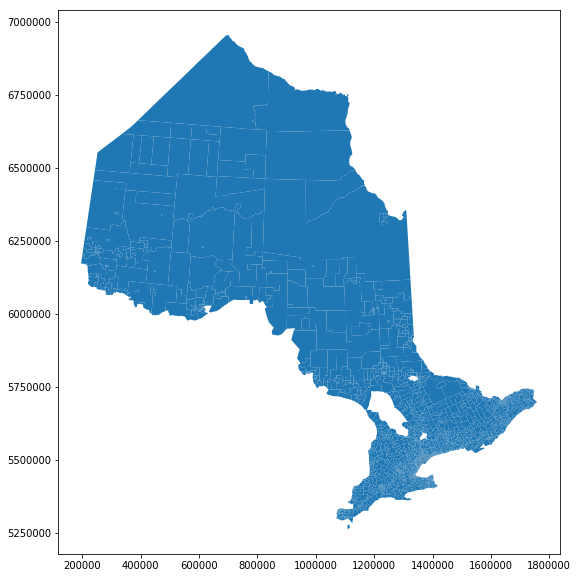

In [5]:
shp_file = './Ontario/Polling Division Shapefile - 2018 General Election'
Ontario = gpd.read_file(shp_file)
Ontario.plot(figsize=(10, 10))

There are many columns we do not need. Below drop them and keep

* **RidingID** - Unique ID number for each Riding Prevously kept in ED_ID column
* **Riding**- English name of the Riding
* **PollID** - Each Riding is made up of many polling districts at this stage this is also the ID column for each individual geometry.
* **geometry** - This is the column containing the shape of the polling districts

This dataframe is useful for a poll by poll breakdown of Election results.

In [31]:
dist = Ontario[['ED_ID',
                'ED_NAME_EN',
                'PD_NUMBER',
                'geometry']].rename(columns = {'ED_ID': 'RidingID',
                                               'ED_NAME_EN': 'Riding',
                                               'PD_NUMBER': 'PollID'})
dist['Riding'] = dist.Riding.astype('str').str.replace('', '-')
dist['RidingID'] = dist.RidingID.astype('int64')
dist['PollID'] = dist.PollID.astype('int64')

In [32]:
dist.head()

,RidingID,Riding,PollID,geometry
0,16,Cambridge,57,"POLYGON ((1302399.697999999 5452280.620000001,..."
1,16,Cambridge,39,"POLYGON ((1308858.901000001 5454087.202, 13090..."
2,16,Cambridge,43,"POLYGON ((1298922.971000001 5452305.68, 129895..."
3,16,Cambridge,29,"POLYGON ((1297921.546999998 5453198.785, 12979..."
4,16,Cambridge,49,"POLYGON ((1299990.865999997 5452462.552999999,..."


To get the Ridings which each seat represents we must dissolve each electoral district into its Riding by RidingID.

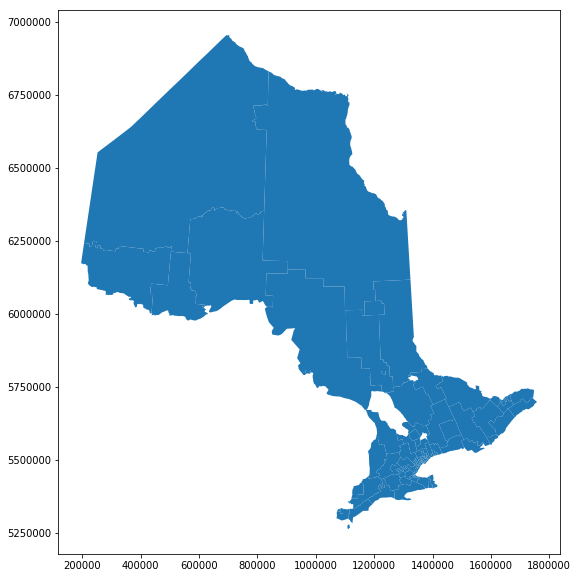

In [33]:
e_dist = dist.dissolve(by = 'RidingID').reset_index()
e_dist.plot(figsize=(10, 10))

## 2018 Valid Votes for Each Candidate

In [34]:
path = './Ontario/Valid Votes Cast for Each Candidate - 2018 General Election - Excel/Summary of Valid Votes Cast for Each Candidate - ED'

vote_sum = pd.DataFrame(columns=['RidingID',
                                 'Riding_name',
                                 'total',
                                 'percentage',
                                 'party',
                                 'cand']) 

Below iterates through a folder extracts election results and concatinates them with **vote_sum** the empty data frame defined above.

In [15]:
for i in range(1, 125): 
    hold= pd.DataFrame(columns=['RidingID',
                                 'Riding_name',
                                 'total',
                                 'percentage',
                                 'party',
                                 'cand'])
    if i < 10:
        c_path = path + '00' + str(i) + '.xls' 
        Poll_District = pd.read_excel(io = c_path, header = None)
        hold.total = Poll_District.loc[11:, 4].dropna()
        hold.percentage = Poll_District.loc[11:, 5].dropna()
        hold.party = Poll_District.loc[11:, 6].dropna()
        hold.cand = Poll_District.loc[11:, 7].dropna()
        hold.Riding_name = Poll_District.loc[12, 0]
        hold.RidingID = i
        hold = hold.fillna(method='ffill')
        vote_sum=pd.concat([vote_sum, hold], ignore_index=True)
    if i > 9 and i < 100:
        c_path = path + '0' + str(i) + '.xls'
        Poll_District = pd.read_excel(io = c_path, header = None)
        hold.total = Poll_District.loc[11:, 4].dropna()
        hold.percentage = Poll_District.loc[11:, 5].dropna()
        hold.party = Poll_District.loc[11:, 6].dropna()
        hold.cand = Poll_District.loc[11:, 7].dropna()
        hold.Riding_name = Poll_District.loc[12, 0]
        hold.RidingID = i
        hold = hold.fillna(method='ffill')
        vote_sum=pd.concat([vote_sum, hold], ignore_index=True)
    if i > 99:
        c_path = path + str(i) + '.xls'
        Poll_District = pd.read_excel(io = c_path, header = None)
        hold.total = Poll_District.loc[11:, 4].dropna()
        hold.percentage = Poll_District.loc[11:, 5].dropna()
        hold.party = Poll_District.loc[11:, 6].dropna()
        hold.cand = Poll_District.loc[11:, 7].dropna()
        hold.Riding_name = Poll_District.loc[12, 0]
        hold.RidingID = i
        hold = hold.fillna(method='ffill')
        vote_sum=pd.concat([vote_sum, hold], ignore_index=True)


In [17]:
vote_sum.RidingID = vote_sum.RidingID.astype("int64")
vote_sum.Riding_name = vote_sum.Riding_name.astype("str").str.title()
vote_sum.total = vote_sum.total.astype("int64")
vote_sum.percentage = vote_sum.percentage.astype("float64")
vote_sum.party = vote_sum.party.astype("str")
vote_sum.cand = vote_sum.cand.astype("str").str.title()
vote_sum['cand_id'] = range(1, len(vote_sum)+1)
vote_sum.head()

,RidingID,Riding_name,total,percentage,party,cand,cand_id
0,1,Ajax,19078,39.0,PCP,Rodney Phillips,1
1,1,Ajax,15130,31.0,NDP,Monique Hughes,2
2,1,Ajax,12607,25.8,LIB,Louis Dickson,3
3,1,Ajax,1224,2.5,GPO,Stephen Leahy,4
4,1,Ajax,312,0.6,LTN,Marsha Haynes,5


Election Ontario's Data was less than ideal for this process so required cleaning below.

* **RidingID** - Na's filled with last scene value and set as an Integer
* **Riding_name**- set as a string
* **total** - total number of votes for candidate set as string in order to replace commas then saves as integer (I am sure there is a better way to do this)
* **percentage** - percentage of the votes passed turned into a string to remove % sign and then turned into a float
* **party** - party's letter code
* **cand** -name of candidate for party (* represents incumbent candidate)
* **candID** -created and unique id for each candidate

In [18]:
major_p = ['LIB', 'PCP', 'NDP', 'GPO'] # 4 major parties in this election that won seats
party_name_dict = {'LIB': 'Liberal',
                   'PCP': 'Conservative',
                   'NDP':'NDP',
                   'GPO': 'Green Party'}
percentages = vote_sum.loc[vote_sum['party']\
                           .isin(major_p)]\
                           .pivot(index= 'RidingID',
                                  columns ='party',
                                  values='percentage')\
                           .reset_index()\
                           .rename(columns=party_name_dict)
percentages.head()

party,RidingID,Green Party,Liberal,NDP,Conservative
0,1,2.5,25.8,31.0,39.0
1,2,3.5,8.1,58.6,24.5
2,3,2.7,21.6,18.0,56.0
3,4,7.2,12.5,28.6,50.0
4,5,11.7,13.6,28.2,44.7


**Percentages** is a pivot table that uses Party as column for each RidingID. below we merge this with the Geopandas dataframe we prepared above.

In [35]:
on_election = gpd.GeoDataFrame(pd.merge(e_dist, percentages))

In [36]:
reduce = on_election.total_bounds.min()
on_election.geometry = on_election.geometry.scale(xfact=(1/reduce), yfact=(1/reduce), zfact=1, origin=(0,0))
on_election.head()

,RidingID,geometry,Riding,PollID,Green Party,Liberal,NDP,Conservative
0,1,"POLYGON ((7.156140508061282 28.09331250594655,...",Ajax,705,2.5,25.8,31.0,39.0
1,2,"POLYGON ((5.159545613159177 29.31536761033756,...",Algoma-Manitoulin,706,3.5,8.1,58.6,24.5
2,3,"POLYGON ((6.965685088060592 28.11617816727144,...",Aurora-Oak Ridges-Richmond Hill,7,2.7,21.6,18.0,56.0
3,4,"POLYGON ((6.920984692730973 28.37734320719479,...",Barrie-Innisfil,10,7.2,12.5,28.6,50.0
4,5,"POLYGON ((6.864965483848776 28.39001315115104,...",Barrie-Springwater-Oro-Medonte,11,11.7,13.6,28.2,44.7


Below we create 4 columns to tell what place each party came in for each riding.

In [37]:
ranks = on_election[['Green Party', 'Liberal', 'NDP', 'Conservative']].rank(axis='columns', ascending = False)

In [38]:
on_election['First']= ranks.where(ranks==1.0).idxmax(axis='columns').astype('str')
on_election['Second']=ranks.where(ranks==2.0).idxmax(axis='columns').astype('str')
on_election['Third']=ranks.where(ranks==3.0).idxmax(axis='columns').astype('str')
on_election['Fourth']=ranks.where(ranks==4.0).idxmax(axis='columns').astype('str')

#### Guelph not appearing
Guelph were not showing up on the maps. This was because Guelph was within another Geometry that was plotted after due to a lower index. Below I add 200 to there RidingID, Set the index, sort by the index, and then reset the index and change their RidingID back.

In [27]:
on_election.loc[on_election.Riding.isin(['Guelph'])] 

,RidingID,geometry,Riding,PollID,Green Party,Liberal,NDP,Conservative,First,Second,Third,Fourth
123,33,"POLYGON ((6.637255080855201 27.88807649896454,...",Guelph,42,45.0,10.1,21.6,21.8,Green Party,Conservative,NDP,Liberal


In [28]:
on_election.RidingID.loc[on_election.Riding.isin(['Guelph'])]= 233
on_election.loc[on_election.Riding.isin(['Guelph'])]

C:\Users\benti\Miniconda3\envs\ele2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,RidingID,geometry,Riding,PollID,Green Party,Liberal,NDP,Conservative,First,Second,Third,Fourth
123,233,"POLYGON ((6.637255080855201 27.88807649896454,...",Guelph,42,45.0,10.1,21.6,21.8,Green Party,Conservative,NDP,Liberal


In [29]:
on_election = on_election.set_index(['RidingID']).sort_index().reset_index()
on_election.RidingID.loc[on_election.Riding.isin(['Guelph'])]= 33
on_election

C:\Users\benti\Miniconda3\envs\ele2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,RidingID,geometry,Riding,PollID,Green Party,Liberal,NDP,Conservative,First,Second,Third,Fourth
0,1,"POLYGON ((7.156140508061282 28.09331250594655,...",Ajax,705,2.5,25.8,31.0,39.0,Conservative,NDP,Liberal,Green Party
1,2,"POLYGON ((5.159545613159177 29.31536761033756,...",Algoma-Manitoulin,706,3.5,8.1,58.6,24.5,NDP,Conservative,Liberal,Green Party
2,3,"POLYGON ((6.965685088060592 28.11617816727144,...",Aurora-Oak Ridges-Richmond Hill,7,2.7,21.6,18.0,56.0,Conservative,Liberal,NDP,Green Party
3,4,"POLYGON ((6.920984692730973 28.37734320719479,...",Barrie-Innisfil,10,7.2,12.5,28.6,50.0,Conservative,NDP,Liberal,Green Party
4,5,"POLYGON ((6.864965483848776 28.39001315115104,...",Barrie-Springwater-Oro-Medonte,11,11.7,13.6,28.2,44.7,Conservative,NDP,Liberal,Green Party
5,6,"POLYGON ((7.952531434689813 28.2322023188064, ...",Bay of Quinte,408,3.4,14.9,31.8,48.0,Conservative,NDP,Liberal,Green Party
6,7,"POLYGON ((7.034804070035993 27.99408129916668,...",Beaches-East York,703,4.3,27.0,48.2,18.4,NDP,Liberal,Conservative,Green Party
7,8,"POLYGON ((6.839563621639138 28.0007109943772, ...",Brampton Centre,16,3.1,17.3,38.4,38.1,NDP,Conservative,Liberal,Green Party
8,9,"POLYGON ((6.880426957289192 28.01317043775798,...",Brampton East,3,1.4,16.6,46.9,33.5,NDP,Conservative,Liberal,Green Party
9,10,"POLYGON ((6.846837984100287 28.01562633047386,...",Brampton North,13,3.4,21.2,37.5,36.3,NDP,Conservative,Liberal,Green Party


## Write Clean File

In [47]:
os.chdir("./Cleaned Data")
file = open("2018_Ontario_Election.json", "w+")
file.write(on_election.to_json())
file.close

<function TextIOWrapper.close()>